In [3]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
from matplotlib import cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd 
import matplotlib.style as stl
from cmath import isnan
stl.use('dark_background')

# Research question and background

Background:

In 2022, the governing body of Formula One, one of the most prestigious motorsport series, enacted changes that fundamentally shifted the aerodynamic philosophy in cars, bringing back ground effect, a technique for generating downforce, not seen since the 1980s. This was Announced in 2019, following 6 years of dominance by the same manufacturer, Mercedes, and their star Driver, Lewis Hamilton. Additionally, development time restrictions were enacted, so top teams like Mercedes had less wind tunnel time than less successful teams. Fans and officials alike were hopeful for more competitive racing. One of the benefits of ground effect is it directs more air above and behind cars, which makes it easier for other cars to follow and attempt overtakes. The goal of our project is to analyze whether the 2022 regulation changes were successful.

In order to perform this, we will be using data from the API FastF1. FastF1 is the most reliable source for all formula 1 data. They have data for every practice, qualifying and race session of the year and both pre-season test sessions. Within each session, there are thousands of laps of recorded data, including lap times, sector times, mini-sector times, positions, tyre type, weather data, track temperature, and telemetry data. Every race weekend generates hundreds of megabytes of data, and the large struggle of this phase was learning how to deal with so much data. We have only scratched the surface of whats possible with our exploratory analysis.

Research question:
1. Did the 2022 regulation changes make racing more competitive?

This question could be approached from multiple angles. For this Phase of the project, we chose to focus on analyzing qualifying and race position for every race of 2021 and 2022, as well as analyzing average position change among the top constructors and midfield cars. Although we could have done more questions, during brainstorming, we found that most questions relating to performance are derivative of this overarching questions. On top of aerodynamic changes, there were massive changes to the types of tyres teams could use, as well as changes to the engine. Thus, future analysis will likely include more discussion and analysis of these elements of Formula 1. 

# Data collection and cleaning

In [4]:
ff1.Cache.enable_cache('/Users/javi/Library/Caches')

This is to store data in a local cache so its easier to access in the future. Even using this feature, data prep can take minutes. Without it, it would be in the tens of minutes.

In [5]:
# All the race and qualifying data for the 2022 season
race_diff_1_2, race_diff_1_3, race_diff_1_5, quali_diff_1_2, quali_diff_1_3, quali_diff_1_5, podiums2022, midfields2022 = [], [], [], [], [], [], [], []
calendar_2022 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

for round in range(1,20):
    # Part 1: collecting race data from the API, and calculating the time difference between first and second, third, and fifth in finishing the race
    race = ff1.get_session(2022, round, "R")
    race.load()
    results = race.results
    race_diff_1_2.append((results['Time'][1] - results['Time'][0]).total_seconds())
    race_diff_1_3.append((results['Time'][2] - results['Time'][0]).total_seconds())
    race_diff_1_5.append((results['Time'][4] - results['Time'][0]).total_seconds())

    # Part 2: collecting qualifying data from the API, and calculating the time difference between first and second, third, and fifth during qualifying
    quali = ff1.get_session(2022, round, "Q")
    quali.load()
    q3 = quali.results.Q3
    quali_diff_1_2.append((q3[1] - q3[0]).total_seconds())
    quali_diff_1_3.append((q3[2] - q3[0]).total_seconds())
    quali_diff_1_5.append((q3[4] - q3[0]).total_seconds())

    # Part 3: collecting data on the average difference between starting and finishing position for the podium finishers (1-3) and the midfield (4-10), respectively 
    grid = results.GridPosition
    finish = results.Position
    diff = abs(grid - finish)
    podium = diff[:3]
    midfield = diff[3:11]
    podiums2022.append((sum(podium) / len(podium)))
    midfields2022.append((sum(midfield) / len(midfield)))

# Part 4: dataframe preparation for figures 1 and 2
race_diff_1_2 = np.array(race_diff_1_2)
race_diff_1_3 = np.array(race_diff_1_3)
race_diff_1_5 = np.array(race_diff_1_5)
race_diff_1_2_avg = race_diff_1_2 / (sum(race_diff_1_2) / len(race_diff_1_2))
race_diff_1_3_avg = race_diff_1_3 / (sum(race_diff_1_3) / len(race_diff_1_3))
race_diff_1_5_avg = race_diff_1_5 / (sum(race_diff_1_5) / len(race_diff_1_5))
race_df_season_2022 = pd.DataFrame({'First to second': race_diff_1_2, 'First to third': race_diff_1_3, 'First to fifth': race_diff_1_5}, index = calendar_2022)
race_df_season_2022_avg = pd.DataFrame({'First to second average': race_diff_1_2_avg, 'First to third average ': race_diff_1_3_avg, 'First to fifth average': race_diff_1_5_avg}, index = calendar_2022)

# Part 5: dataframe preparation for figures 3 and 4
quali_diff_1_2 = np.array(quali_diff_1_2)
quali_diff_1_3 = np.array(quali_diff_1_3)
quali_diff_1_5 = np.array(quali_diff_1_5)
one_two_avg = sum(quali_diff_1_2) / len(quali_diff_1_2)
one_three_avg = sum(quali_diff_1_3) / len(quali_diff_1_3)
one_five_avg = sum(quali_diff_1_5) / len(quali_diff_1_5)
quali_diff_1_2_avg = quali_diff_1_2 / one_two_avg
quali_diff_1_3_avg = quali_diff_1_3 / one_three_avg
quali_diff_1_5_avg = quali_diff_1_5 / one_five_avg
quali_df_season_2022 = pd.DataFrame({'First to second': quali_diff_1_2, 'First to third': quali_diff_1_3, 'First to fifth': quali_diff_1_5}, index = calendar_2022)
quali_df_season_2022_avg = pd.DataFrame({'First to second average': quali_diff_1_2_avg, 'First to third average ': quali_diff_1_3_avg, 'First to fifth average': quali_diff_1_5_avg}, index = calendar_2022)

# Part 6: dataframe preparation for figure 9
df_2022_changes = pd.DataFrame({'Podium': podiums2022, 'Midfield': midfields2022}, index = calendar_2022)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_dat

Since we are using FastF1, an API, the data we are retrieving has already been cleaned. The tradeoff, however, is that we need to be extremely concise with what data we want to use, since FastF1 generates hundreds of gigabytes per race. The above cell shows all the preparation that goes into the figures displaying data from 2022. The data is easily accessible by importing FastF1 into python and calling the API. Documentation for the API is found here: https://theoehrly.github.io/Fast-F1/

First, there is a for loop, which loops over 19 times. This is because there have been 19 races in the 2022 championship (so far), and with each loop, we collect the race and qualifying data for each car. This include sector times, fastest lap, finishing posiiton, starting position, for every lap. This data is then filtered through in the for loop, and the relevant data is added to numppy arrays to then be used for calculations. This covers parts 1-3 commented in the cell above. 

Second, after the loop, parts 4-6 takes the arrays from the for loop above, and prepares the data in dataframes for visualization. In total, we produce 5 dataframes.

In [6]:
# All the race and qualifying data for the 2021 season
race_diff_1_2, race_diff_1_3, race_diff_1_5, quali_diff_1_2, quali_diff_1_3, quali_diff_1_5, podiums2021, midfields2021= [], [], [], [], [], [], [], []
calendar_2021 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

for round in range(1,23):
    # collecting race data from the API, and calculating the time difference between first and second, third, and fifth in finishing the race
    race = ff1.get_session(2021, round, "R")
    race.load()
    results = race.results
    race_diff_1_2.append((results['Time'][1] - results['Time'][0]).total_seconds())
    race_diff_1_3.append((results['Time'][2] - results['Time'][0]).total_seconds())
    race_diff_1_5_value = (results['Time'][4] - results['Time'][0]).total_seconds()
    race_diff_1_5_value = race.laps.pick_fastest().LapTime.total_seconds() if isnan(race_diff_1_5_value) else race_diff_1_5_value
    (race_diff_1_5).append(race_diff_1_5_value)

    # collecting qualifying data from the API, and calculating the time difference between first and second, third, and fifth during qualifying
    quali = ff1.get_session(2021, round, "Q")
    quali.load()
    q3 = quali.results.Q3
    quali_diff_1_2.append((q3[1] - q3[0]).total_seconds())
    quali_diff_1_3.append((q3[2] - q3[0]).total_seconds())
    quali_diff_1_5.append((q3[4] - q3[0]).total_seconds())

    # collecting data on the average difference between starting and finishing position for the podium finishers (1-3) and the midfield (4-10), respectively 
    grid = results.GridPosition
    finish = results.Position
    diff = abs(grid - finish)
    podium = diff[:3]
    midfield = diff[3:11]
    podiums2021.append((sum(podium) / len(podium)))
    midfields2021.append((sum(midfield) / len(midfield)))

# dataframe preparation for figures 5 and 6
race_diff_1_2 = np.array(race_diff_1_2)
race_diff_1_3 = np.array(race_diff_1_3)
race_diff_1_5 = np.array(race_diff_1_5)
race_diff_1_2_avg = race_diff_1_2 / (sum(race_diff_1_2) / len(race_diff_1_2))
race_diff_1_3_avg = race_diff_1_3 / (sum(race_diff_1_3) / len(race_diff_1_3))
race_diff_1_5_avg = race_diff_1_5 / (sum(race_diff_1_5) / len(race_diff_1_5))
race_df_season_2021 = pd.DataFrame({'First to second': race_diff_1_2, 'First to third': race_diff_1_3, 'First to fifth': race_diff_1_5}, index = calendar_2021)
race_df_season_2021_avg = pd.DataFrame({'First to second average': race_diff_1_2_avg, 'First to third average ': race_diff_1_3_avg, 'First to fifth average': race_diff_1_5_avg}, index = calendar_2021)

# dataframe preparation for figures 7 and 8
quali_diff_1_2 = np.array(quali_diff_1_2)
quali_diff_1_3 = np.array(quali_diff_1_3)
quali_diff_1_5 = np.array(quali_diff_1_5)
one_two_avg = sum(quali_diff_1_2) / len(quali_diff_1_2)
one_three_avg = sum(quali_diff_1_3) / len(quali_diff_1_3)
one_five_avg = sum(quali_diff_1_5) / len(quali_diff_1_5)
quali_diff_1_2_avg = quali_diff_1_2 / one_two_avg
quali_diff_1_3_avg = quali_diff_1_3 / one_three_avg
quali_diff_1_5_avg = quali_diff_1_5 / one_five_avg
quali_df_season_2021 = pd.DataFrame({'First to second': quali_diff_1_2, 'First to third': quali_diff_1_3, 'First to fifth': quali_diff_1_5})
quali_df_season_2021_avg = pd.DataFrame({'First to second average': quali_diff_1_2_avg, 'First to third average ': quali_diff_1_3_avg, 'First to fifth average': quali_diff_1_5_avg}, index = calendar_2021)

# dataframe preparation for figure 10
df_2021_changes = pd.DataFrame({'Podium': podiums2021, 'Midfield': midfields2021}, index = calendar_2021)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data


The data cleaning and preparation process in the cell above is similar to the process for the 2022 data. The difference here is there are 22 loops instead of 19.

In [7]:
# load data
quali = ff1.get_session(2022, 1, "Q")
quali.load()

# select Leclerc and Verstappen laps
laps_charles = quali.laps.pick_driver('LEC')
laps_max = quali.laps.pick_driver('VER')

# select each ones fastest lap
fastest_charles = laps_charles.pick_fastest()
fastest_max = laps_max.pick_fastest()

# extract telemetry data
telemetry_charles = fastest_charles.get_telemetry().add_distance()
telemetry_max = fastest_max.get_telemetry().add_distance()

# for visualizaiton colors
ferrari = fastest_charles['Team']
rb = fastest_max['Team']

#extract delta values for the first visualization (requires three variables, but we only use the delta and reference telemetries)
delta, telemetry, spare = utils.delta_time(fastest_charles, fastest_max)

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']


The cell above shows the data preparation  process for the telemetry data of the two fastest laps during qualifying for the first race of the 2022 season. For each Leclerc and Verstappen, we found all their laps during qualifying, found the fastest lap of those, and extracted the telemetry data for that lap, and compared the two fastest laps to find the delta over the whole lap.

# Data description

In [8]:
display(race_df_season_2022)
display(race_df_season_2022_avg)
display(quali_df_season_2022)
display(quali_df_season_2022_avg)
display(df_2022_changes)

,First to second,First to third,First to fifth
1,5.598,9.675,14.754
2,0.549,8.097,32.732
3,20.524,25.593,53.303
4,16.527,34.834,43.181
5,3.786,8.229,18.582
6,13.072,32.927,54.534
7,1.154,1.491,11.968
8,20.823,45.995,77.299
9,0.993,7.006,15.168
10,3.779,6.225,9.571


,First to second average,First to third average,First to fifth average
1,0.641508,0.539219,0.412660
2,0.062913,0.451272,0.915493
3,2.351966,1.426379,1.490850
4,1.893926,1.941410,1.207745
5,0.433860,0.458628,0.519726
6,1.497998,1.835127,1.525281
7,0.132244,0.083098,0.334737
8,2.386230,2.563448,2.162003
9,0.113794,0.390467,0.424239
10,0.433058,0.346939,0.267695


,First to second,First to third,First to fifth
1,0.123,0.129,0.680
2,0.025,0.202,0.868
3,0.286,0.372,0.957
4,0.779,1.132,1.203
5,0.190,0.195,0.679
6,0.323,0.416,0.670
7,0.225,0.253,0.473
8,0.282,0.347,1.353
9,0.645,0.797,1.661
10,0.072,0.315,1.012


,First to second average,First to third average,First to fifth average
1,0.553529,0.391972,0.729202
2,0.112506,0.613785,0.930805
3,1.287068,1.130337,1.026244
4,3.505685,3.439629,1.290044
5,0.855045,0.592516,0.728130
6,1.453577,1.264033,0.718478
7,1.012553,0.768751,0.507224
8,1.269067,1.054374,1.450897
9,2.902653,2.421718,1.781183
10,0.324017,0.957141,1.085224


,Podium,Midfield
1,1.000000,3.250
2,1.000000,2.125
3,1.333333,2.875
4,1.000000,4.500
5,1.333333,5.000
6,1.666667,3.750
7,1.000000,1.875
8,1.333333,2.875
9,0.666667,5.125
10,1.333333,5.500


In [9]:
display(race_df_season_2021)
display(race_df_season_2021_avg)
display(quali_df_season_2021)
display(quali_df_season_2021_avg)
display(df_2021_changes)

,First to second,First to third,First to fifth
1,0.745,37.383,52.047
2,22.000,23.702,27.036
3,29.148,33.530,51.369
4,15.841,26.610,63.671
5,8.968,19.427,52.591
6,1.385,2.762,4.754
7,2.904,8.811,64.032
8,35.743,46.907,67.058
9,17.973,20.019,57.144
10,3.871,11.125,42.624


,First to second average,First to third average,First to fifth average
1,0.054262,1.440492,1.062959
2,1.602378,0.913317,0.552158
3,2.123006,1.292023,1.049112
4,1.153785,1.025372,1.300356
5,0.653188,0.748587,1.074069
6,0.100877,0.106429,0.097091
7,0.211514,0.339517,1.307729
8,2.603355,1.807484,1.369529
9,1.309070,0.771399,1.167055
10,0.281946,0.428684,0.870512


,First to second,First to third,First to fifth
0,0.388,0.589,0.812
1,0.035,0.087,0.379
2,0.007,0.398,0.691
3,0.036,0.132,0.839
4,0.230,0.255,0.274
5,0.232,0.345,0.358
6,0.258,0.386,0.850
7,0.194,0.226,0.327
8,0.048,0.270,0.329
9,0.075,0.194,0.710


,First to second average,First to third average,First to fifth average
1,1.836094,1.537677,1.119018
2,0.165627,0.227127,0.522300
3,0.033125,1.039041,0.952268
4,0.170359,0.344607,1.156227
5,1.088406,0.665717,0.377600
6,1.097871,0.900676,0.493360
7,1.220908,1.007713,1.171386
8,0.918047,0.590008,0.450639
9,0.227146,0.704877,0.453395
10,0.354915,0.506467,0.978452


,Podium,Midfield
1,0.666667,2.250
2,2.333333,3.000
3,1.333333,3.000
4,0.000000,1.500
5,1.666667,2.250
6,5.000000,3.625
7,0.333333,3.500
8,0.666667,2.250
9,1.333333,3.500
10,1.000000,2.250


The previous two code cells display the five possible dataframes extracted from each season. ***race_df_season_2022*** oberves the time difference in seconds between first and second (column 1), first and third (column 2), and first and fifth (column 3). ***race_df_season_2022_avg*** displays similar data, except each row is divided by the average value for the respective column across the season. For example, Column 1 in ***race_df_season_2022_avg*** is like column 1 in ***race_df_season_2022*** except each value is divided by the season average time difference between first and second in order to gain an understanding of whether  or not this race was competitive or not.

***quali_df_season_2022*** and ***quali_df_season_2022_avg*** show similar data to the previous paragraph, except instead of showing the difference in race finish, its the difference between first and second, third, and fifth during qualifying, respectively.

The ***df_2022_changes*** shows the average number of position changes during a race. The first column shows the average number of position changes among the podium finishers, and column two shows the average number of position changes among the midfield drivers.

Everything said applies to the second cell above, except the data is from 2021.

Below are examples of what a single loop through the qualifying and results data produces. Keep in mind, we loop through 82 of these combined in order to create the data you see above.

In [10]:
display(results)
display(quali.results)

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
33,33,M VERSTAPPEN,VER,Red Bull Racing,0600EF,Max,Verstappen,Max Verstappen,1.0,1.0,NaT,NaT,NaT,0 days 01:30:17.345000,Finished,26.0
44,44,L HAMILTON,HAM,Mercedes,00D2BE,Lewis,Hamilton,Lewis Hamilton,2.0,2.0,NaT,NaT,NaT,0 days 01:30:19.601000,Finished,18.0
55,55,C SAINZ,SAI,Ferrari,DC0004,Carlos,Sainz,Carlos Sainz,3.0,5.0,NaT,NaT,NaT,0 days 01:30:22.518000,Finished,15.0
22,22,Y TSUNODA,TSU,AlphaTauri,2B4562,Yuki,Tsunoda,Yuki Tsunoda,4.0,8.0,NaT,NaT,NaT,0 days 01:30:23.037000,Finished,12.0
10,10,P GASLY,GAS,AlphaTauri,2B4562,Pierre,Gasly,Pierre Gasly,5.0,12.0,NaT,NaT,NaT,0 days 01:30:23.876000,Finished,10.0
77,77,V BOTTAS,BOT,Mercedes,00D2BE,Valtteri,Bottas,Valtteri Bottas,6.0,6.0,NaT,NaT,NaT,0 days 01:30:24.808000,Finished,8.0
4,4,L NORRIS,NOR,McLaren,FF9800,Lando,Norris,Lando Norris,7.0,3.0,NaT,NaT,NaT,0 days 01:31:16.545000,Finished,6.0
14,14,F ALONSO,ALO,Alpine,0090FF,Fernando,Alonso,Fernando Alonso,8.0,11.0,NaT,NaT,NaT,0 days 01:31:19.053000,Finished,4.0
31,31,E OCON,OCO,Alpine,0090FF,Esteban,Ocon,Esteban Ocon,9.0,9.0,NaT,NaT,NaT,0 days 01:31:21.371000,Finished,2.0
16,16,C LECLERC,LEC,Ferrari,DC0004,Charles,Leclerc,Charles Leclerc,10.0,7.0,NaT,NaT,NaT,0 days 01:31:23.402000,Finished,1.0


,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,Ferrari,ed1c24,Charles,Leclerc,Charles Leclerc,1.0,0.0,0 days 00:01:31.471000,0 days 00:01:30.932000,0 days 00:01:30.558000,NaT,,0.0
1,1,M VERSTAPPEN,VER,Red Bull Racing,1e5bc6,Max,Verstappen,Max Verstappen,2.0,0.0,0 days 00:01:31.785000,0 days 00:01:30.757000,0 days 00:01:30.681000,NaT,,0.0
55,55,C SAINZ,SAI,Ferrari,ed1c24,Carlos,Sainz,Carlos Sainz,3.0,0.0,0 days 00:01:31.567000,0 days 00:01:30.787000,0 days 00:01:30.687000,NaT,,0.0
11,11,S PEREZ,PER,Red Bull Racing,1e5bc6,Sergio,Perez,Sergio Perez,4.0,0.0,0 days 00:01:32.311000,0 days 00:01:31.008000,0 days 00:01:30.921000,NaT,,0.0
44,44,L HAMILTON,HAM,Mercedes,6cd3bf,Lewis,Hamilton,Lewis Hamilton,5.0,0.0,0 days 00:01:32.285000,0 days 00:01:31.048000,0 days 00:01:31.238000,NaT,,0.0
77,77,V BOTTAS,BOT,Alfa Romeo,b12039,Valtteri,Bottas,Valtteri Bottas,6.0,0.0,0 days 00:01:31.919000,0 days 00:01:31.717000,0 days 00:01:31.560000,NaT,,0.0
20,20,K MAGNUSSEN,MAG,Haas F1 Team,b6babd,Kevin,Magnussen,Kevin Magnussen,7.0,0.0,0 days 00:01:31.955000,0 days 00:01:31.461000,0 days 00:01:31.808000,NaT,,0.0
14,14,F ALONSO,ALO,Alpine,2293d1,Fernando,Alonso,Fernando Alonso,8.0,0.0,0 days 00:01:32.346000,0 days 00:01:31.621000,0 days 00:01:32.195000,NaT,,0.0
63,63,G RUSSELL,RUS,Mercedes,6cd3bf,George,Russell,George Russell,9.0,0.0,0 days 00:01:32.269000,0 days 00:01:31.252000,0 days 00:01:32.216000,NaT,,0.0
10,10,P GASLY,GAS,AlphaTauri,4e7c9b,Pierre,Gasly,Pierre Gasly,10.0,0.0,0 days 00:01:32.096000,0 days 00:01:31.635000,0 days 00:01:32.338000,NaT,,0.0


In [11]:
display(laps_charles)
display(fastest_charles)
display(telemetry_charles)
display(delta)
display(telemetry)

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedST,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 00:23:24.977000,16,NaT,1,1,0 days 00:21:25.144000,NaT,NaT,0 days 00:00:47.783000,0 days 00:00:37.692000,...,189.0,SOFT,1.0,True,0 days 00:21:25.144000,Ferrari,LEC,1,False,2022-03-19 15:06:26.073
1,0 days 00:24:56.448000,16,0 days 00:01:31.471000,2,1,NaT,NaT,0 days 00:00:29.367000,0 days 00:00:39.067000,0 days 00:00:23.037000,...,314.0,SOFT,2.0,True,0 days 00:23:24.977000,Ferrari,LEC,1,True,2022-03-19 15:08:25.906
2,0 days 00:26:49.497000,16,0 days 00:01:53.049000,3,2,NaT,0 days 00:26:47.694000,0 days 00:00:35.658000,0 days 00:00:49.179000,0 days 00:00:28.212000,...,247.0,SOFT,1.0,True,0 days 00:24:56.448000,Ferrari,LEC,1,False,2022-03-19 15:09:57.377
3,0 days 00:44:52.882000,16,NaT,4,2,0 days 00:43:05.158000,NaT,NaT,0 days 00:00:45.919000,0 days 00:00:29.579000,...,192.0,SOFT,5.0,False,0 days 00:26:49.497000,Ferrari,LEC,1,False,2022-03-19 15:11:50.426
4,0 days 00:46:24.238000,16,0 days 00:01:31.356000,5,2,NaT,NaT,0 days 00:00:29.413000,0 days 00:00:39.065000,0 days 00:00:22.878000,...,315.0,SOFT,6.0,False,0 days 00:44:52.882000,Ferrari,LEC,1,True,2022-03-19 15:29:53.811
5,0 days 00:48:11.172000,16,0 days 00:01:46.934000,6,3,NaT,0 days 00:48:09.380000,0 days 00:00:33.843000,0 days 00:00:45.777000,0 days 00:00:27.314000,...,253.0,SOFT,4.0,False,0 days 00:46:24.238000,Ferrari,LEC,1,False,2022-03-19 15:31:25.167
6,0 days 00:52:57.658000,16,NaT,7,3,0 days 00:51:08.067000,NaT,NaT,0 days 00:00:47.622000,0 days 00:00:28.327000,...,185.0,SOFT,2.0,True,0 days 00:48:11.172000,Ferrari,LEC,1,False,2022-03-19 15:33:12.101
7,0 days 00:54:28.590000,16,0 days 00:01:30.932000,8,3,NaT,NaT,0 days 00:00:29.355000,0 days 00:00:38.850000,0 days 00:00:22.727000,...,312.0,SOFT,3.0,True,0 days 00:52:57.658000,Ferrari,LEC,1,True,2022-03-19 15:37:58.587
8,0 days 00:56:17.533000,16,0 days 00:01:48.943000,9,4,NaT,0 days 00:56:15.707000,0 days 00:00:34.668000,0 days 00:00:45.679000,0 days 00:00:28.596000,...,280.0,SOFT,1.0,True,0 days 00:54:28.590000,Ferrari,LEC,1,False,2022-03-19 15:39:29.519
9,0 days 01:05:57.048000,16,NaT,10,4,0 days 01:04:09.214000,NaT,NaT,0 days 00:00:49.713000,0 days 00:00:25.004000,...,190.0,SOFT,2.0,True,0 days 00:56:17.533000,Ferrari,LEC,1,False,2022-03-19 15:41:18.462


Time                      0 days 01:14:47.968000
DriverNumber                                  16
LapTime                   0 days 00:01:30.558000
LapNumber                                     14
Stint                                          5
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:29.115000
Sector2Time               0 days 00:00:38.702000
Sector3Time               0 days 00:00:22.741000
Sector1SessionTime        0 days 01:13:46.525000
Sector2SessionTime        0 days 01:14:25.227000
Sector3SessionTime        0 days 01:14:47.968000
SpeedI1                                    241.0
SpeedI2                                    270.0
SpeedFL                                    288.0
SpeedST                                    316.0
Compound                                    SOFT
TyreLife                                     3.0
FreshTyre                                   True
LapStartTime        

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance
2,2022-03-19 15:58:18.339,0 days 01:13:17.410000,,591.047778,0 days 00:00:00,10514,292,7,100,False,12,interpolation,0.000006,OnTrack,-380,1280,-159,0.000000
3,2022-03-19 15:58:18.423,0 days 01:13:17.494000,,591.047778,0 days 00:00:00.084000,10502,293,7,100,False,12,pos,0.001283,OnTrack,-377,1350,-159,6.836667
4,2022-03-19 15:58:18.491,0 days 01:13:17.562000,,591.047778,0 days 00:00:00.152000,10478,294,8,100,False,12,car,0.002319,OnTrack,-373,1413,-158,12.390000
5,2022-03-19 15:58:18.723,0 days 01:13:17.794000,,591.047778,0 days 00:00:00.384000,10519,295,8,100,False,12,pos,0.005868,OnTrack,-362,1661,-158,31.401111
6,2022-03-19 15:58:18.731,0 days 01:13:17.802000,77,591.047778,0 days 00:00:00.392000,10560,296,8,100,False,12,car,0.005991,OnTrack,-361,1669,-157,32.058889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2022-03-19 15:59:48.503,0 days 01:14:47.574000,77,465.962778,0 days 00:01:30.164000,11636,288,7,100,False,12,pos,0.991791,OnTrack,-396,961,-159,5329.548333
695,2022-03-19 15:59:48.611,0 days 01:14:47.682000,77,464.673889,0 days 00:01:30.272000,11495,289,7,100,False,12,car,0.993405,OnTrack,-391,1045,-159,5338.218333
696,2022-03-19 15:59:48.683,0 days 01:14:47.754000,77,462.607222,0 days 00:01:30.344000,11064,289,7,100,False,12,pos,0.994483,OnTrack,-389,1106,-159,5343.998333
697,2022-03-19 15:59:48.851,0 days 01:14:47.922000,77,460.540556,0 days 00:01:30.512000,10634,290,7,100,False,12,car,0.997002,OnTrack,-382,1242,-158,5357.531667


0      0.000000
1     -0.000281
2      0.000115
3      0.000063
4     -0.000742
         ...   
332    0.316662
333    0.315559
334    0.314747
335    0.301000
336    0.255000
Name: Time, Length: 337, dtype: float64

,Date,SessionTime,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,Distance
0,2022-03-19 15:58:18.339,0 days 01:13:17.410000,10502,293,7,100,False,12,interpolation,0 days 00:00:00,0.000000
1,2022-03-19 15:58:18.491,0 days 01:13:17.562000,10478,294,8,100,False,12,car,0 days 00:00:00.152000,12.413333
2,2022-03-19 15:58:18.731,0 days 01:13:17.802000,10560,296,8,100,False,12,car,0 days 00:00:00.392000,32.146667
3,2022-03-19 15:58:19.131,0 days 01:13:18.202000,10696,299,8,100,False,12,car,0 days 00:00:00.792000,65.368889
4,2022-03-19 15:58:19.291,0 days 01:13:18.362000,10696,300,8,100,False,12,car,0 days 00:00:00.952000,78.702222
...,...,...,...,...,...,...,...,...,...,...,...
332,2022-03-19 15:59:48.291,0 days 01:14:47.362000,11547,286,7,100,False,12,car,0 days 00:01:29.952000,5313.132222
333,2022-03-19 15:59:48.451,0 days 01:14:47.522000,11778,288,7,100,False,12,car,0 days 00:01:30.112000,5325.932222
334,2022-03-19 15:59:48.611,0 days 01:14:47.682000,11495,289,7,100,False,12,car,0 days 00:01:30.272000,5338.776667
335,2022-03-19 15:59:48.851,0 days 01:14:47.922000,10634,290,7,100,False,12,car,0 days 00:01:30.512000,5358.110000


The above cell shows the data for Leclerc's qualifying session, including all his laps, his fastest lap, the telemetry for that fastest lap, the delta between his lap and Verstappen's lap, and the difference in telemetry data between the two drivers. As the telemetry dataframe shows, there are over 600 rows for one lap. Over a weekend, this translates to upwards of 20,000 laps in all combined sessions. In order to familiarize ourselves with telemetry data, we only perform analysis on two laps for this phase.

# Exploratory data analysis

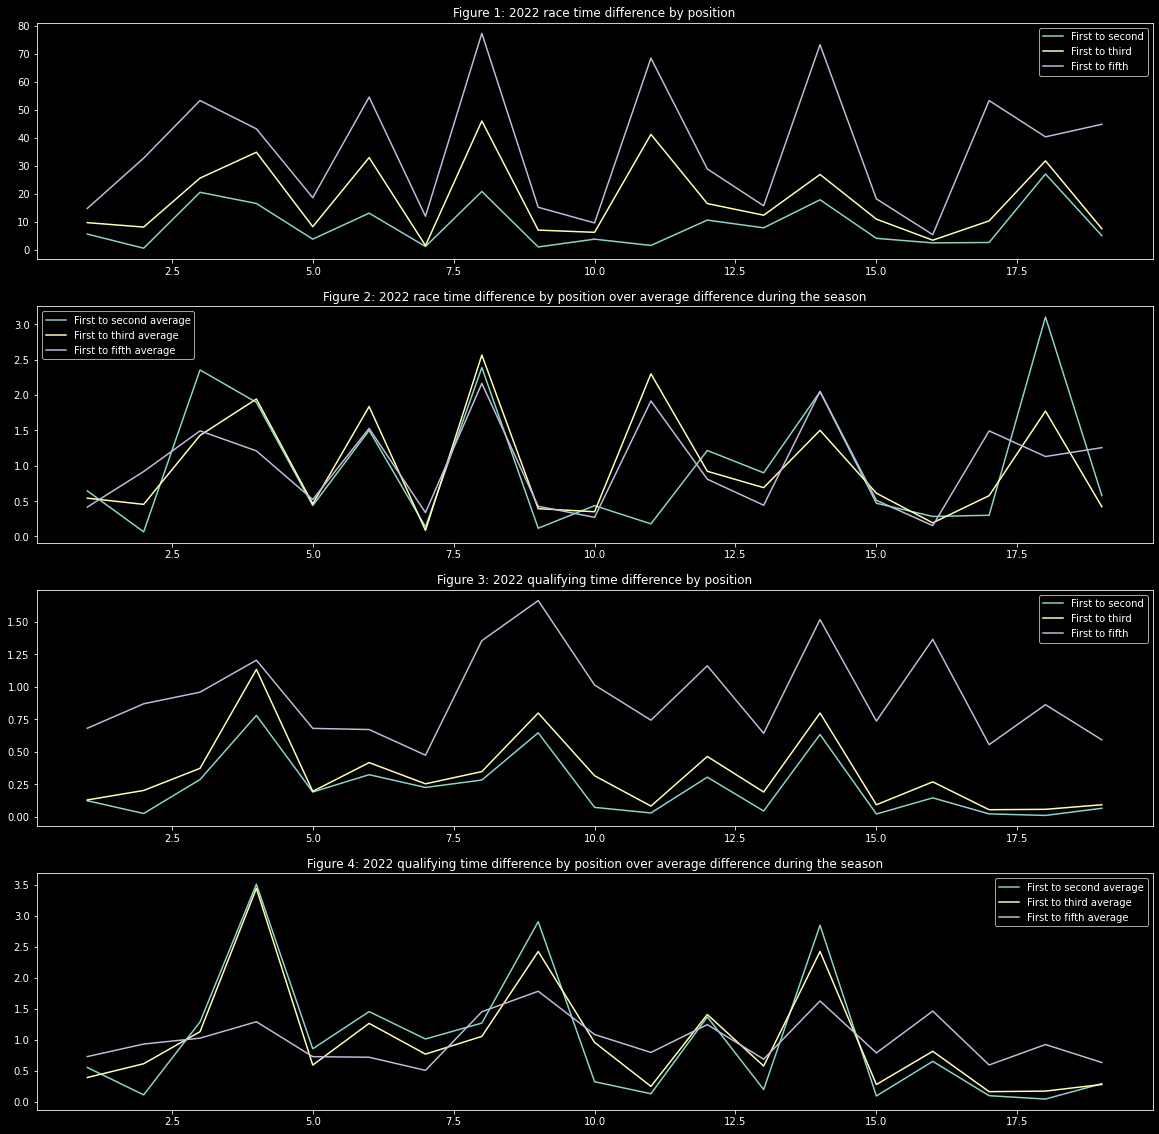

In [12]:
fig, axs = plt.subplots(4, figsize = (20, 20))
axs[0].set_title('Figure 1: 2022 race time difference by position')
axs[0].plot(race_df_season_2022)
axs[0].legend(race_df_season_2022)
axs[1].set_title('Figure 2: 2022 race time difference by position over average difference during the season')
axs[1].plot(race_df_season_2022_avg)
axs[1].legend(race_df_season_2022_avg)
axs[2].set_title('Figure 3: 2022 qualifying time difference by position')
axs[2].plot(quali_df_season_2022)
axs[2].legend(quali_df_season_2022)
axs[3].set_title('Figure 4: 2022 qualifying time difference by position over average difference during the season')
axs[3].plot(quali_df_season_2022_avg)
axs[3].legend(quali_df_season_2022_avg)

Figures 1 shows the time difference between the first and second, third, and fifth place finishers during every race for the 2022 season. Figure 2 shows similar results, except every race's time difference is divided by the average time between the first and second, third, and fifth place finish for the whole season. For both graphs, its difficult to see of there is a clear competitive gap trend at any of the three levels suggested. With this type of visualization, competitiveness can also be skewed by the fact that some races finish under safety cars or have safety cares near the end of the race. This changes how competitive a race can appear, as safety cars mean drivers cannot exceed certain speeds while race marshalls ensure safety, and so the field tends to bunch up, reducing the time difference between the race leader and the field.

Figure 3 shows the time difference between first and second, third, and fifth during each qualifying session of the 2022 season. The benefit of using qualifying positions as a guide to competitiveness is that unlike race finishes, qualifying positions are less likely to be affected by things like safety cars. Thus, there appears to be a clearer trend as after race weekend 6, there is a spike in the difference between the first and fifth place qualifiers. Before week 6, the difference between first and fifth hovered below 0.75 seconds, but after, it is consistently well above 0.75 seconds. By contrast, for most of the season, the 1st to 3rd and 1st to 2nd place lines follow pretty closely, suggesting that the top three are in close competition. The large gap in 1st to 5th and the lack of gap between 2nd and 3rd suggests that there is a large gap between the top drivers and the midfield, and this gap grew larger during the season. 

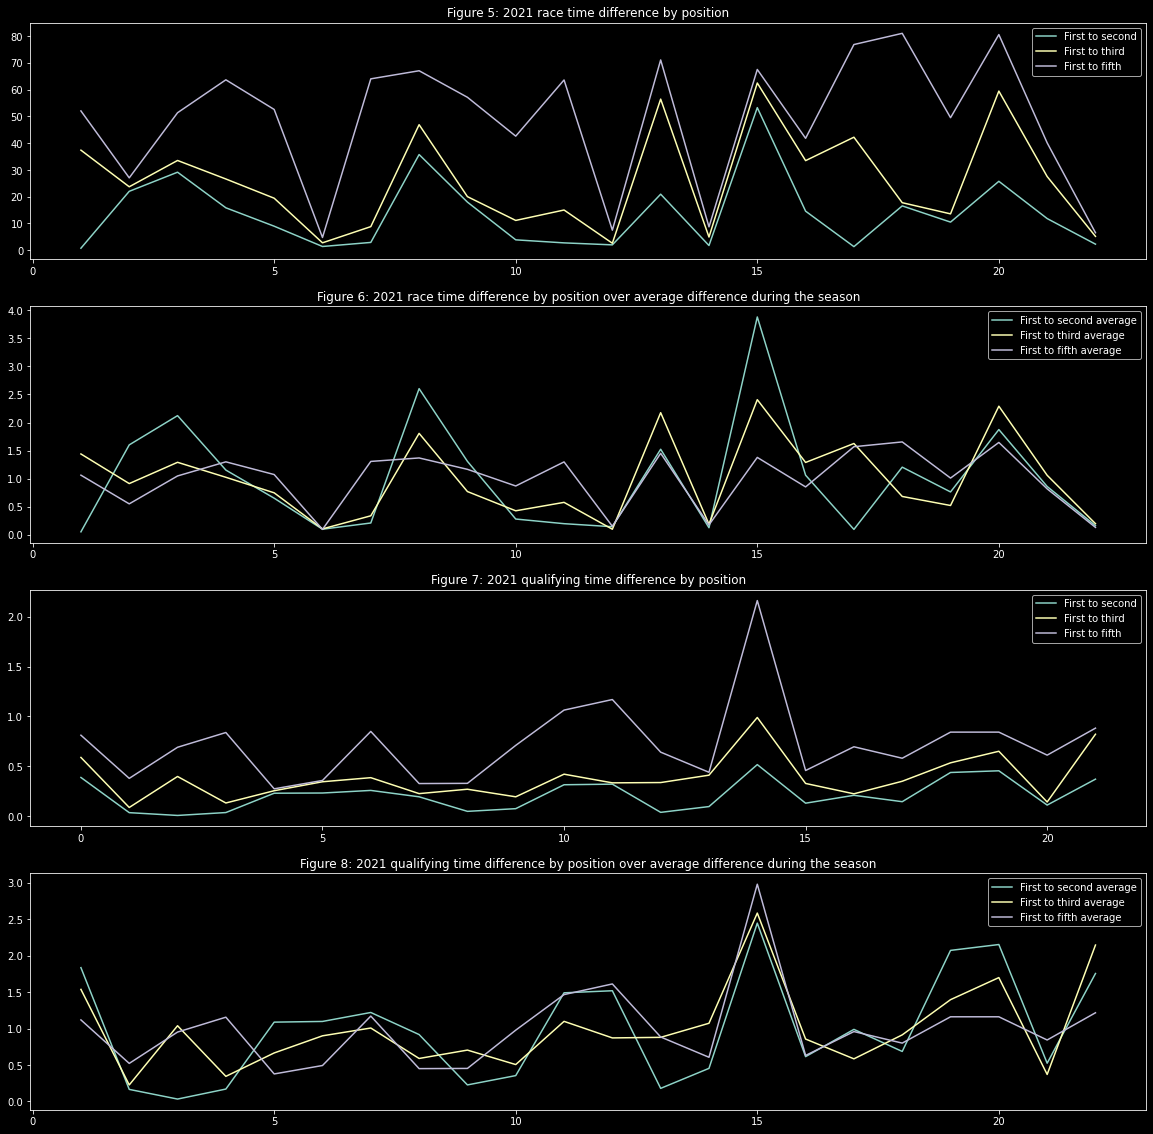

In [13]:
fig, axs = plt.subplots(4, figsize = (20, 20))
axs[0].set_title('Figure 5: 2021 race time difference by position')
axs[0].plot(race_df_season_2021)
axs[0].legend(race_df_season_2021)
axs[1].set_title('Figure 6: 2021 race time difference by position over average difference during the season')
axs[1].plot(race_df_season_2021_avg)
axs[1].legend(race_df_season_2021_avg)
axs[2].set_title('Figure 7: 2021 qualifying time difference by position')
axs[2].plot(quali_df_season_2021)
axs[2].legend(quali_df_season_2021)
axs[3].set_title('Figure 8: 2021 qualifying time difference by position over average difference during the season')
axs[3].plot(quali_df_season_2021_avg)
axs[3].legend(quali_df_season_2021_avg)

Figure 5 shows the time difference between first and second, third, and fifth, respectively, for the 2021. Figure 6 shows those values divided by the average distance between each respective position for the whole year. This is useful in contrast to to figures 1 and 2, which show the same visualizations but during the 2022 season. A trend we noticed was that the there was a larger disparity between the fifth and third place finishers in 2021 than in 2022. Again, its difficult to be certain about trends when things like safety cars can make races seem more competitive than they were, this suggests that the gap between the midfield and the top driver was larger in 2021 than 2022, Although the gap between 1st and 3rd is larger in 2022 than in 2021. This presents a more nuanced view of competitiveness, where perhaps the regulation changes made the midfield more competitive, while the fight for race wins and podium positions is more one-sided.

Figures 7 and 8 show the same as figures 5 and 6 but for the 2021 season, respectively. Figure 6 shows that although the gaps between the leader and 2nd, 3rd, and 5th varies race by race, the difference between 1st and 5th hovered between 0.5 and 0.75 seconds for most of the season.

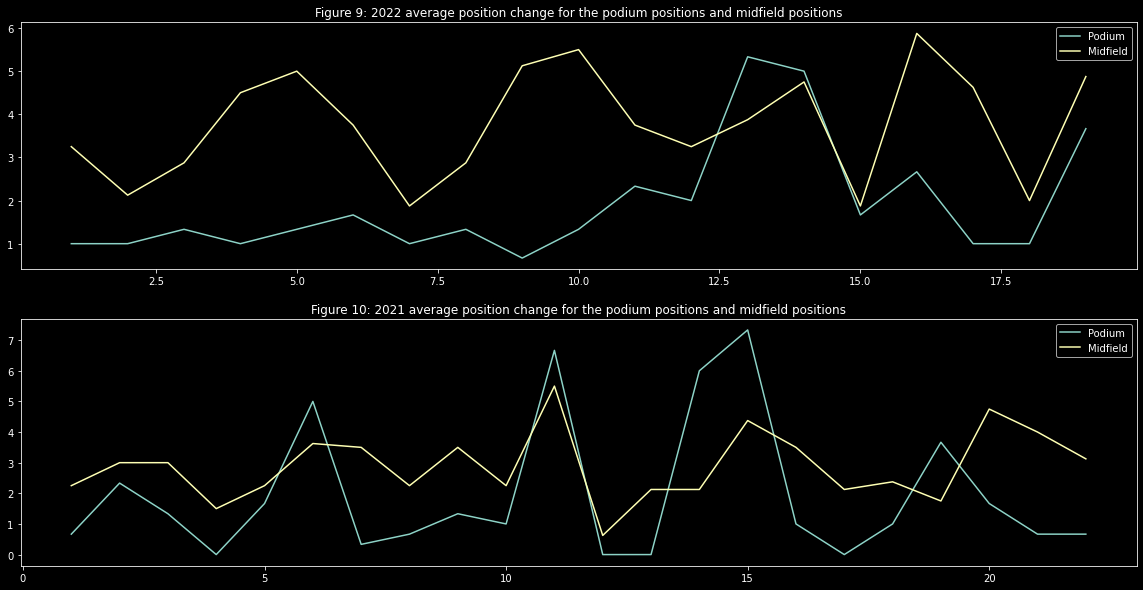

In [14]:
fig, axs = plt.subplots(2, figsize = (20, 10))
axs[0].set_title('Figure 9: 2022 average position change for the podium positions and midfield positions')
axs[0].plot(df_2022_changes)
axs[0].legend(df_2022_changes)
axs[1].set_title('Figure 10: 2021 average position change for the podium positions and midfield positions')
axs[1].plot(df_2021_changes)
axs[1].legend(df_2021_changes)

Figures 9 and 10 tell a more interesting and nuanced story of competitiveness between the 2021 and 2022 seasons. Figure 9 shows how many positions changes the podium finishers and midfield cars experienced. In green, the podium finishers line was calculated by finding the average of the difference between the starting and finishing positions of the top 3 finishers. The same was done with the yellow line, or the midfield cars, except it calculates it using the cars that finished 4th-10th. The same is done in figure 10 but with the 2021 season.

What the visualizations show is that the midfield is more exciting and competitive this year, but that the race for podium positions is often uncompetitive. For all of 2022, the average number of position changes in the midfield fell between 2 and 6, while it hovered around 2 for most of 2021. Of course there are outlier races, but this trend persists for the whole of each respective season. By contrast, for the first 10 races of 2022, the average position change among podium finishers was around or below 1 change, indicating that drivers who qualified in the top 3 tended to finish in the top 3, showing a a lack of competitive racing.

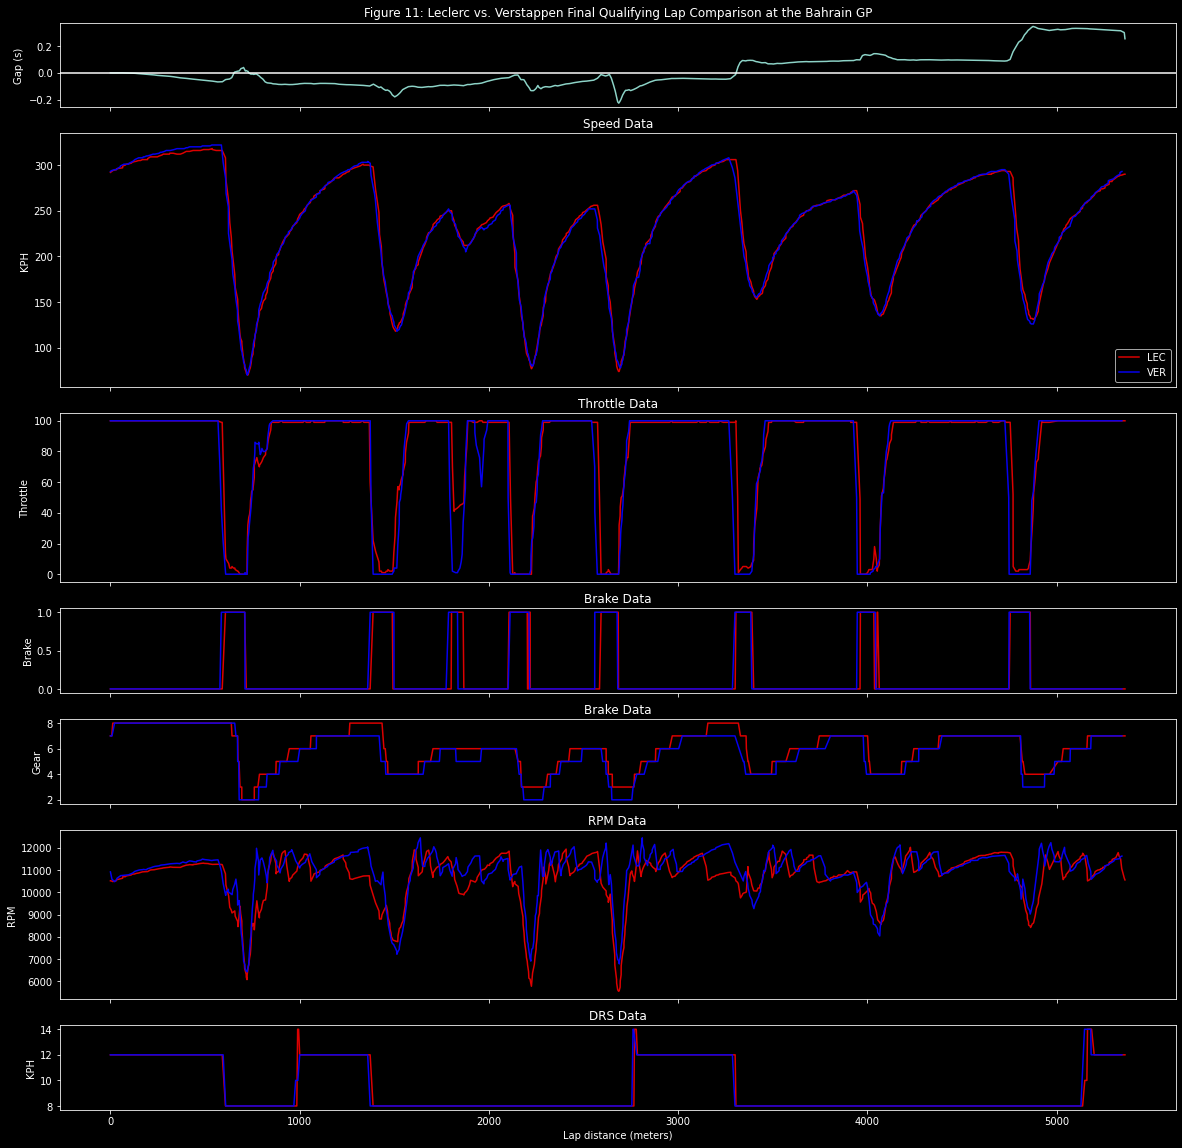

In [15]:
fig, ax = plt.subplots(7, gridspec_kw={'height_ratios': [1, 3, 2, 1, 1, 2, 1]}, figsize = (20, 20))
ax[0].title.set_text('Figure 11: Leclerc vs. Verstappen Final Qualifying Lap Comparison at the Bahrain GP')

# Time delta visualization
ax[0].plot(telemetry['Distance'], delta)
ax[0].axhline(0)
ax[0].set(ylabel="Gap (s)")

# Speed visualization
ax[1].title.set_text("Speed Data")
ax[1].plot(telemetry_charles['Distance'], telemetry_charles['Speed'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[1].plot(telemetry_max['Distance'], telemetry_max['Speed'], label='VER', color=ff1.plotting.team_color(rb))
ax[1].set(ylabel='KPH')
ax[1].legend(loc="lower right")

# Throttle visualization
ax[2].title.set_text("Throttle Data")
ax[2].plot(telemetry_charles['Distance'], telemetry_charles['Throttle'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[2].plot(telemetry_max['Distance'], telemetry_max['Throttle'], label='VER', color=ff1.plotting.team_color(rb))
ax[2].set(ylabel='Throttle')

# Brake visualization
ax[3].title.set_text("Brake Data")
ax[3].plot(telemetry_charles['Distance'], telemetry_charles['Brake'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[3].plot(telemetry_max['Distance'], telemetry_max['Brake'], label='VER', color=ff1.plotting.team_color(rb))
ax[3].set(ylabel='Brake')

# Gear visualization
ax[4].title.set_text("Brake Data")
ax[4].plot(telemetry_charles['Distance'], telemetry_charles['nGear'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[4].plot(telemetry_max['Distance'], telemetry_max['nGear'], label='VER', color=ff1.plotting.team_color(rb))
ax[4].set(ylabel='Gear')

# RPM visualization
ax[5].title.set_text("RPM Data")
ax[5].plot(telemetry_charles['Distance'], telemetry_charles['RPM'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[5].plot(telemetry_max['Distance'], telemetry_max['RPM'], label='VER', color=ff1.plotting.team_color(rb))
ax[5].set(ylabel='RPM')

# DRS visualization
ax[6].title.set_text("DRS Data")
ax[6].plot(telemetry_charles['Distance'], telemetry_charles['DRS'], label='LEC', color=ff1.plotting.team_color(ferrari))
ax[6].plot(telemetry_max['Distance'], telemetry_max['DRS'], label='VER', color=ff1.plotting.team_color(rb))
ax[6].set(ylabel='KPH')
ax[6].set(xlabel='Lap distance (meters)')


for a in ax.flat:
    a.label_outer()
plt.show()

Figure 11 is different from the previous 10, as it only shows the lap data for the two fastest laps of qualifying at the 2022 Bahrain GP, the first race of the year. We chose to include this visualization to help illustrate just how powerful FastF1. This is the data for only two laps, and already, it shows how detailed our data analysis can be. Looking at the first subgraph, the time delta between the two drivers is in Verstappen's favor 2/3rds into the lap, but in the third sector, Leclerc manages to pull away from Verstappen. This is corroborated by the speed subgraph, as Leclerc carries slightly more speed into the corners in the third sectors, indicated by the red line dropping off slightly later than the blue line. This graph alone is only ann anecdotal analysis of our research question, but helps to illustrate how detailed our final phase analysis will be with the overflow of telemetry data.

/usr/local/lib/python3.9/site-packages/fastf1/core.py:1093: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Russian Grand Prix - Race [v2.2.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '3', '77', '14', '4', '7', '11', '63', '18', '5', '10', '31', '16', '99', '22', '9', '6', '47']
/usr/local/lib/python3.9/site-packages/fastf1/core.py:1093: FutureWarning: `Session.load_laps` is deprecated and wil

Optimization terminated successfully.
         Current function value: 1.055749
         Iterations 5


/var/folders/0j/1rhcqn_173b1sxlypl_4f72w0000gn/T/ipykernel_41959/1330716768.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime']= race_laps["LapTime"].dt.total_seconds()


Text(0.5, 1.0, 'Figure 13: Actual tires used during the 2021 Russian GP')

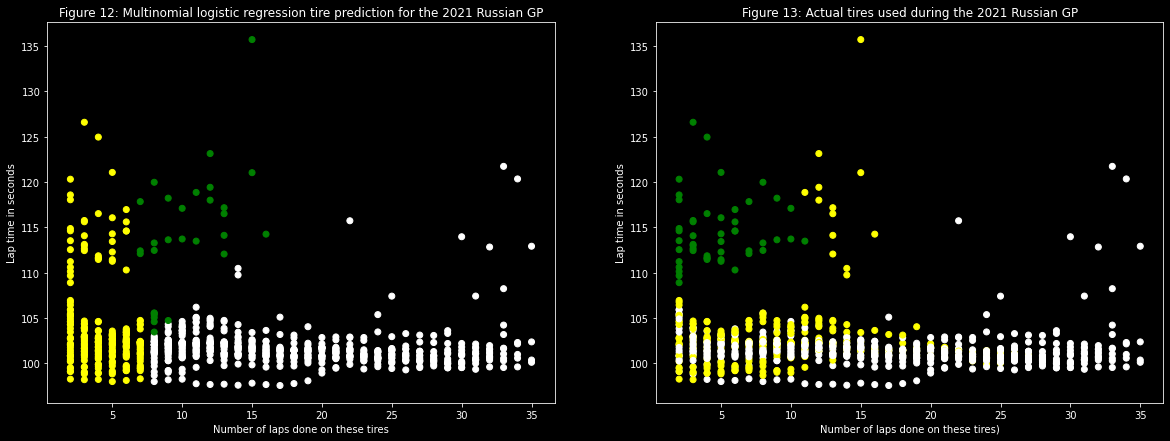

In [25]:
race = ff1.get_session(2021, 'Russia', 'R')
fp1 = ff1.get_session(2021, 'Russia', 'FP1')
fp2 = ff1.get_session(2021, 'Russia', 'FP2')
race_laps = race.load_laps()
fp1_laps = fp1.load_laps()
fp2_laps = fp2.load_laps()
fp_laps = pd.concat([fp1_laps, fp2_laps])
fp_laps = fp_laps.loc[fp_laps['IsAccurate'] == True]
fp_laps['LapTime']= fp_laps["LapTime"].dt.total_seconds()
fp_laps = fp_laps.reset_index(drop=True)
train = fp_laps[['LapTime', 'TyreLife', 'Driver', 'Compound']]
train = train.loc[np.logical_not(np.isnan(train['TyreLife']))]
train = train.reset_index(drop=True)
y_train = train['Compound']
X_train = train[['LapTime', 'TyreLife']]
train["Color"] = np.where(
    train["Compound"] == "SOFT","Red", np.where(
        train["Compound"] == "MEDIUM", "Yellow",np.where(
            train["Compound"] == "HARD", "White", "Green")
    )
)
logit_model = sm.MNLogit(y_train,sm.add_constant(X_train))
results = logit_model.fit()
race_laps = race_laps.loc[race_laps['IsAccurate'] == True]
race_laps['LapTime']= race_laps["LapTime"].dt.total_seconds()
race_laps = race_laps.reset_index(drop=True)
test = race_laps[['LapTime', 'TyreLife', 'Driver', 'Compound']]
test = test.loc[np.logical_not(np.isnan(test['TyreLife']))]
test = test.reset_index(drop=True)
y_test = test['Compound']
X_test = test[['LapTime', 'TyreLife']]
yhat = logit_model.predict(results.params, sm.add_constant(X_test))
colors = ['green', 'white', 'yellow']
final = []
for row in yhat:
    maximum = max(row)
    final.append(colors[np.where(row == maximum)[0][0]])
test['Colors'] = final
test["Actual"] = np.where(
    test["Compound"] == "SOFT","Red", np.where(
        test["Compound"] == "MEDIUM", "Yellow",np.where(
            test["Compound"] == "HARD", "White", "Green")
    )
)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))

ax1.scatter(test["TyreLife"], test["LapTime"], c= test['Colors'])
ax1.set_xlabel("Number of laps done on these tires")
ax1.set_ylabel("Lap time in seconds")
ax1.set_title("Figure 12: Multinomial logistic regression tire prediction for the 2021 Russian GP")

ax2.scatter(test["TyreLife"], test["LapTime"], c= test['Actual'])
ax2.set_xlabel("Number of laps done on these tires)")
ax2.set_ylabel("Lap time in seconds")
ax2.set_title("Figure 13: Actual tires used during the 2021 Russian GP")

This is our first attempt at a logistic regression. Since there are more than two tyre types, we needed to use a multinomial logistic regression. As figure 12 shows, the regression did well in classifying the hard compound tyre stints, as the values on the right on the x-axis were all largely correctly predicted to be on the hard tyre. It similarly did well to identify medium tyre stints, as they tended to have low lap times and fewer laps completed than the hard compound stints. Where the model struggled, however, was with intermediate tyre stints. It did not predict intermediate tyre use very well. This could have something to do with the training data. One thing we struggled with when trying this model out was how to train the model. We decided, for our first try, to use only free practice data to train the model, and use race data to test the model.

# Data limitations

Since so much data is generated every race weekend, it took us a while to get a grip on how best to prepare the data for visualizations. For the purpose of simplicity and getting up to speed, we chose to limit our data analysis to 2021 and 2022. For the final phase, we will be extending this to include more years, to gain a better understanding for competitiveness of a larger period of time.

Additionally, although figures 1-10 are related and all look at season-wide competitiveness for either 2021 or 2022, and either qualifying or the race. In addition to performing analysis on more seasons, we hope to combine season0wide data with the depth of data provided by telemetry data. For this phase, we found the task two daunting. It took us a close reading of the documentation to produce figure 11, and the hope would be to perform this analysis on thousands of laps. The limitation lies with out ability to synthesize so much data, but we think its possible.

Figures 12 and 13 show that our approach of using free practice session data may not be the best approach. Additionally, we tried using the 2021 Russian GP first, because this was a race with distinct tyre stint strategies, as the final ten laps were heavily affected by rain. It created an interesting initial testing ground on which to attempt a multinomial logistic regression. Unfortunately, the period before thanksgiving is pretty hectic, and once you've chosen as a team to try this approach and this method, it takes more effort to restart before the assignment is due than there is time to add more models.But, this will be fixed by the time the final project is due, and more models will be added to the final project.

# Questions for reviewers

Given our first logistic regression attempt didn't yield worthwhile results, is it ok if we try a completely new approach, as long as it still uses a logistic regression? Or should we focus on refining our current approach? 